# Weekend Movie Trip
## General Information
1. Author: Patrick McNamee
2. Date: 10/5/2019


## Description
Trying to cluster movies for recommendations. Data used is a small version of the latest dataset from https://grouplens.org/datasets/movielens/

## Initial Data Exploration
Alright, first step is to load the data into panda dataframes to observe what the data looks like in its original form. There are two sets of note which is that the movies are seperate from the users and user ratings.

In [4]:
import pandas as pd

movies = pd.read_csv('./data/original-ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings = pd.read_csv('./data/original-ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Data Feature Engineering
So the movie dataset genres has several unique attributes with movies having one or more genres. This is a prime candadite for one-hot-encoding. Additionally we could likely extract the year of release of the movie 

In [6]:
movies['genres'] = movies['genres'].str.split('|')#Deliminate the list
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
movies = movies.join(pd.DataFrame(mlb.fit_transform(movies.pop('genres')),
                                  columns=mlb.classes_,
                                  index = movies.index)
                    )
movies.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Clustering
## K-Means

Another thing to look at is the relative distributions of of ratings to see if there is any distinct clusters.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

movie_rating = ratings.groupby('movieId')['rating'].mean()
ax = sns.kdeplot(movie_rating, shade=True, color='blue')
plt.show()

<Figure size 640x480 with 1 Axes>

It seems to meet expectations that there is clustering around ratings of 0.5, 1, ..., 4.5, and 5. So perhaps the quickest and easy way to cluster is simply by rating. If a user likes to watch movies that are globally around 3.5, then the algorithm should suggest other movies that are rated around 3.5.

In [9]:
import numpy as np
from sklearn.cluster import KMeans

n_cluster_used = 10 # 0.5:5 intervaled at 0.5
kmeans = KMeans(n_clusters=n_cluster_used, random_state=0).fit(np.array(movie_rating).reshape(-1,1))
kmeans.cluster_centers_

array([[2.04803448],
       [3.73898509],
       [3.01158245],
       [4.42332207],
       [1.51889954],
       [2.54871321],
       [3.43455776],
       [4.97573455],
       [0.80991762],
       [4.01249238]])

## Weighted Graph

If we think of the users as traversing a complete graph between the movies than we can weight the edges of the graph by commonality of what users watched. This should give locally densed areas around genres as well as quality. If people who movie A always watch movie B sometime afterwards then it would make sense to recommend movie B to someone who had yet to see if if there is a strong edge. This analysis does assume that people have told each other about movies and weaker movies are seen by a lot less people.

In [10]:
import igraph as ig

#Create the graph with movies as the verticies
g = ig.Graph.Full(len(ratings.movieId.unique()))
ig.summary(g)

IGRAPH U--- 9724 47273226 -- 


In [11]:
#Setting up graph attritubutes so that you can see the title
g.vs["name"] = movies["title"]
#movie ID is 1 indexed but vertices are 0 indexed
g.es["weight"] = 0.0 #zero weights on tree
g.is_weighted()

True

In [12]:
#generate user
user_movie_watched = ratings.groupby('userId')['movieId'].apply(list)
user_movie_rating = ratings.groupby('userId')['rating'].apply(list)
print(user_movie_rating.head())
print(user_movie_watched.head())

userId
1    [4.0, 4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 5.0, ...
2    [3.0, 4.0, 4.5, 4.0, 4.0, 3.5, 4.0, 4.0, 4.5, ...
3    [0.5, 0.5, 0.5, 0.5, 0.5, 5.0, 0.5, 0.5, 0.5, ...
4    [3.0, 2.0, 3.0, 2.0, 3.0, 3.0, 4.0, 5.0, 1.0, ...
5    [4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, ...
Name: rating, dtype: object
userId
1    [1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163,...
2    [318, 333, 1704, 3578, 6874, 8798, 46970, 4851...
3    [31, 527, 647, 688, 720, 849, 914, 1093, 1124,...
4    [21, 32, 45, 47, 52, 58, 106, 125, 126, 162, 1...
5    [1, 21, 34, 36, 39, 50, 58, 110, 150, 153, 232...
Name: movieId, dtype: object


In [ ]:
# Go through edges i.e. all combinations and weight them
for edge in g.es:
    #getting two vertex indicies in 1 indexing
    v1 = edge.source + 1
    v2 = edge.target + 1
    #for every user
    for movie_list, rating_list in zip(user_movie_watched,
                                       user_movie_rating):
        #if the user watched both movies
        if v1 in movie_list and v2 in movie_list:
            # get the individual movie ratings
            v1index = movie_list.index(v1)
            v2index = movie_list.index(v2)
            v1rating = rating_list[v1index]
            v2rating = rating_list[v2index]
            
            #Update the weight has a fraction
            edge['weight'] = edge['weight'] + (v1rating + v2rating)/10

In [ ]:
#saving since the above code block above takes forever to run (28hrs)
# I'll be the first to admit, the shear size of the graph was
# not a smart choice for demos
import pickle

pickle.dump(g, open(r'./model/graph.p', 'wb+'))

In [2]:
#run in case reset
import igraph as ig
import pickle

g = pickle.load(open(r'./model/graph.p', 'rb'))

At this point I'm running into a lack of memory on my local machine so instead of plotting the entire graph, I'll plot only a subgraph.

In [3]:
g = g.subgraph(g.vs[:100]) #first 1 hundred

In [17]:
#setting up plot of graph
layout = g.layout("lgl")
max_weight = max(g.es["weight"])

visual_style = {}
visual_style["vertex_size"] = 20
visual_style["vertex_color"] = "blue"
visual_style["vertex_label"] = range(100)
visual_style["edge_width"] = [2*int(5*weight/max_weight) 
                              for weight in g.es["weight"]]
visual_style["layout"] = layout
visual_style["bbox"] = (600, 800)
visual_style["margin"] = 20


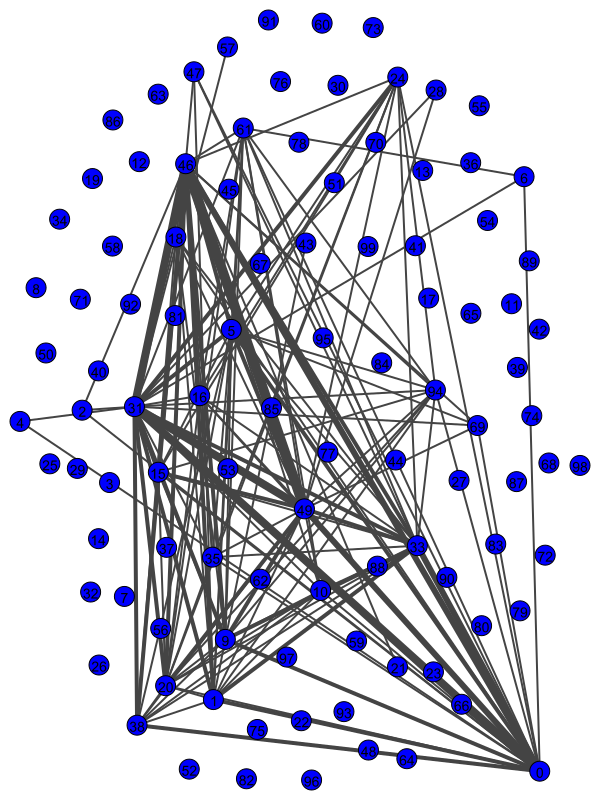

In [18]:
ig.plot(g, **visual_style)
#ig.plot(g, layout=g.layout('lgl'))

So the graph above shows an edge if its weight as determined by $\sum_{user\in Users} (R_1 + R_2)/10$ where $R_1$ and $R_2$ are the two ratings the user gave two the two movies is at least 10% of the maximum weight. It appears that most movies are not popular  and so they have no edges shown. However, there are some like the vertex labeled 0 (Toy Story) which are really popular and hence should be recommended. These popular movies also form highly connected networks that can be exploited. A recommendation algorithm can simply traverse less popular vertices until it gets to a highly connected region and then recommend movies inside of that subgraph.

## Conclusions

Two seperate clustering algorithms are used generate clusters and graphs for movie recommendations for users.